# **Cluster**

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster

## Inputs

* outputs/datasets/collection/mushrooms.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety'

---

# Load Data

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/mushrooms.csv")

print(df.shape)
df.head()

(8124, 23)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,0,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,1,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


---

# Cluster Mushroom Pipeline with all data

## ML Cluster Pipeline

As previously identified in the Data Cleaning notebook, no data cleaning is needed. Target Encoding followed by Smart Correlated Selection will be used as before. Principal Component Analysis will then been performed to extract correlated components that explain the variance in the data. K-means clustering will be applied to the principal components to identify a set number of clusters.

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from category_encoders import TargetEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans

cols = df.columns[df.dtypes=='object'].to_list()

cat_list=[]

for col in cols:
    cat_list.append(list(df[col].unique()))

def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=50, random_state=0)),
        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    return pipeline_base

## Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df, df['edible'])

print(df_pca.shape,'\n', type(df_pca))

(8124, 17) 
 <class 'numpy.ndarray'>


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data to determine how many principal components account for the variance in the data.

* The 17 components explain 100.0% of the data 



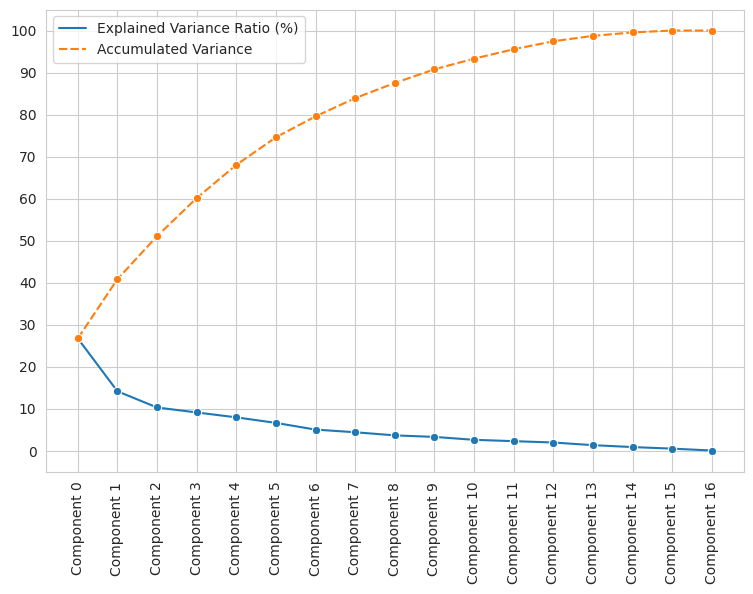

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 17

def pca_components_analysis(df_pca, n_components):
    """ performs analysis on the number of components needed to explain the variance in the dataset and visually plots this """
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum()

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

In order to reduce the complexity of the model, only the most relevant components which explain the majority of the variance in the dataset will be used. For this, we will look at taking the 6 most important components.

* The 6 components explain 74.58% of the data 



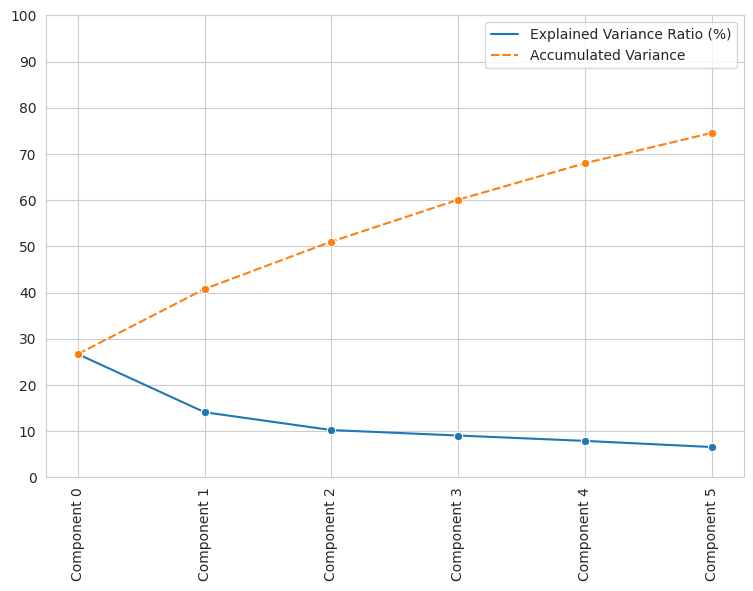

In [8]:
n_components = 6
pca_components_analysis(df_pca=df_pca, n_components=n_components)

Will set `n_components` argument of PCA to 6. 

In [9]:
def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=6, random_state=0)),
        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    return pipeline_base


PipelineCluster()

Pipeline(steps=[('TargetEncoder', TargetEncoder()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=6, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

Initialize the new version of the pipeline, and then fit and transform the data to the feature engineering and PCA steps.

In [16]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df, df['edible'])

print(df_analysis.shape,'\n', type(df_analysis))

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


(8124, 6) 
 <class 'numpy.ndarray'>


Will perform the elbow method to determine the best value of k for the k-means clustering.

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,14)) 
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

The elbow appears at k=6. We will now visualize the change in silhouette score for differing values of k distributed around this value.

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 11

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):
    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0), colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

The elbow on the average silhouette score plot is at k=7. To optimize for both average distortion store and average silhouette score, we will choose 7 clusters. 

## Fit Cluster Pipeline


Define cluster pipeline based on findings of above sections

In [21]:
def PipelineCluster():
    """ Creates a pipeline for a k-means clustering model """
    pipeline_base = Pipeline([
        ("TargetEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("PCA", PCA(n_components=6, random_state=0)),
        ("model", KMeans(n_clusters=7, random_state=0))])
    return pipeline_base


PipelineCluster()

Pipeline(steps=[('TargetEncoder', TargetEncoder()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=6, random_state=0)),
                ('model', KMeans(n_clusters=7, random_state=0))])

Copy of data for training cluster pipeline

In [22]:
X = df.copy()
print(X.shape)
X.head(3)

(8124, 23)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows


Fit Cluster pipeline to data

In [23]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X, X['edible'])

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Pipeline(steps=[('TargetEncoder',
                 TargetEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                     'bruises', 'odor', 'gill-attachment',
                                     'gill-spacing', 'gill-size', 'gill-color',
                                     'stalk-shape', 'stalk-root',
                                     'stalk-surface-above-ring',
                                     'stalk-surface-below-ring',
                                     'stalk-color-above-ring',
                                     'stalk-color-below-ring', 'veil-type',
                                     'veil-color', 'ring-number', 'ring-type',
                                     's...
                                                     'gill-size', 'gill-color',
                                                     'stalk-shape',
                                                     'stalk-root',
                                                     'stalk-s

### Add cluster predictions to dataset

We add a column `Clusters` from the cluster pipeline predictions to the dataset

In [24]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head()

(8124, 24)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,Clusters
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,white,white,partial,white,one,pendant,black,scattered,urban,2
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,white,white,partial,white,one,pendant,brown,numerous,grasses,2
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,white,white,partial,white,one,pendant,brown,numerous,meadows,2
3,0,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,white,white,partial,white,one,pendant,black,scattered,urban,2
4,1,convex,smooth,gray,no,none,free,crowded,broad,black,...,white,white,partial,white,one,evanescent,brown,abundant,grasses,6


* Clusters frequencies 
   Clusters
0      0.26
4      0.23
3      0.17
6      0.13
2      0.12
5      0.07
1      0.02 




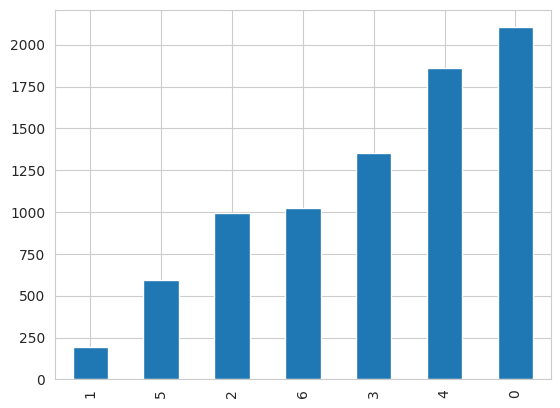

In [25]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Plot Clusters

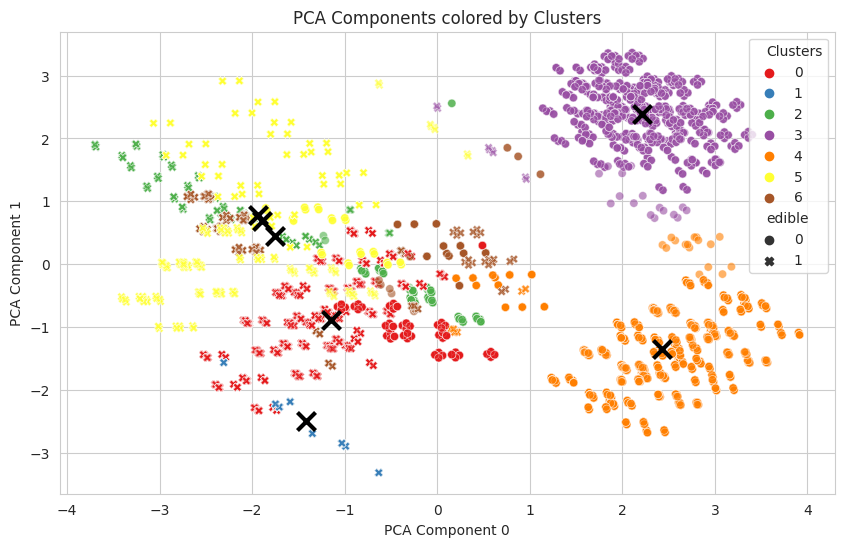

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1], hue=X['Clusters'], style=X['edible'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1], marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

Evaluation: We cross check with metrics defined in the ML business case

* A minimum mean silhouette score of 0.5 on the model's clusters

Getting mean silhouette score and distortion score for the model

In [27]:
from sklearn.metrics import silhouette_samples

sample_silhouette_values = silhouette_samples(df_analysis, X['Clusters'])
num_clusters = 7
cluster_labels = pipeline_cluster['model'].labels_

means_lst = []
for label in range(num_clusters):
    means_lst.append(sample_silhouette_values[cluster_labels == label].mean())

np.mean(means_lst)

0.5214569034060158

In [28]:
pipeline_cluster['model'].inertia_

19810.458264114208

It appears from the plot of PCA components, cluster and edibility above that the clustering model is somewhat successful at identifying unique groupings of mushrooms, which appear distinct in the rates of edibility among them. The model also has an average silhouette score of 0.52, which satisfies the business requirement for this model. 

We save the cluster predictions from this pipeline to use in the future.

In [29]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       2
1       2
2       2
3       2
4       6
       ..
8119    1
8120    1
8121    1
8122    4
8123    1
Name: Clusters, Length: 8124, dtype: int32

---

# Classify Mushroom Pipeline

We copy `X` to a DataFrame `dl_clf`

In [30]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(8124, 24)


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,Clusters
0,0,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,white,white,partial,white,one,pendant,black,scattered,urban,2
1,1,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,white,white,partial,white,one,pendant,brown,numerous,grasses,2
2,1,bell,smooth,white,bruises,anise,free,close,broad,brown,...,white,white,partial,white,one,pendant,brown,numerous,meadows,2


Split Train and Test sets

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters', 'edible'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)

(6499, 22) (1625, 22)


## Create Pipeline

Create classifier pipeline steps. As with the Predict Edible pipeline, this pipeline will use Target Encoding, Smart Correlated Selection, Standard Scaling, Feature Selection, and then will be fitted using an Adaptive Boost Classifier algorithm with the same optimal hyperparameters.

In [32]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

def PipelineClf2ExplainClusters():
    """ generates clf pipeline for classifying mushrooms to cluster """
    pipeline_base = Pipeline([
        ("TargetCategoricalEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.01, n_estimators=500))),
        ("model", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.01, n_estimators=500))
    ])
    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Fit Data

Fit classifier to the training data

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

### Evaluate classifier performance on Train and Test Sets

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

Evaluation: We cross check with metrics defined in the ML business case

* A minimum average recall of 0.7 in predicting the model's cluster

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

The model performs to the required level of precision on the test set, and can therefore be said to be usable for the business case. 

### Most Important Features that Define a Cluster

The variables that were selected for in the Feature Selection step of the pipeline are picked out and plotted in terms of feature importance in the model.

In [ ]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False))

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

We will store the best_features to use at a later stage.

In [ ]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

---

# Cluster Analysis

Load function that plots a table with description for all clusters - the percentages of each category that composes a cluster.

In [ ]:
def DescriptionAllClusters(df, decimal_points=3):
    """  provides a dataframe describing the distribution of categories within the clusters """
    DescriptionAllClusters = pd.DataFrame(columns=df.drop(['Clusters'], axis=1).columns)

    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):
    """ Produces statistical information on the distribution of variable categories in each cluster """
    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)

    for col in EDA_Cluster.columns:
        try:
            top_frequencies = EDA_Cluster.dropna(subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
            Description = ''

            for x in range(len(top_frequencies)):
                freq = top_frequencies.iloc[x]
                category = top_frequencies.index[x][0]
                CategoryPercentage = int(round(freq*100, 0))
                statement = f"'{category}': {CategoryPercentage}% , "
                Description = Description + statement

            ClustersDescription.at[0, col] = Description[:-2]
            
        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

Load a custom function to plot cluster distribution per Variable (absolute and relative levels) - this will be used plot the distribution of edibility among clusters. 

In [ ]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count', color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=df['Clusters'].unique()))
    fig.show()

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)', color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array', tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show()

Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.

In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head()

We want also to analyse edibility levels.

In [ ]:
df_edible = pd.read_csv("outputs/datasets/collection/mushrooms.csv").filter(['edible'])
df_edible['edible'] = df_edible['edible'].astype('object')
df_edible.head(3)

### Cluster profile based on the best features

We produce a profile of the proportion of categories that make up the various clusters, for the variables that were determined to function the best for the Predict Cluster model.

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_edible], axis=1), decimal_points=0)
clusters_profile

### Cluster distribution across edible levels & Relative Percentage of edible in each cluster

In [ ]:
df_cluster_vs_edible=  df_edible.copy()
df_cluster_vs_edible['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_edible, target='edible')

Some insight can be derived about each mushrooms in each cluster from the above:

- Mushrooms in cluster 0:
    - are either in populations of several or solitary
    - typically have broad gill sizes
    - typically have a bulbous stalk root
    - typically have close gill spacing
    - tend to have a stalk color below the ring of white, but can also have gray, or pink. 
    - have pendant stalk ring(s)
    - are usually found in the woods, occasionally in urban or grass habitats.
    - **are usually edible (86% of cluster), but may occasionally be poisonous (14% of cluster)**

* Mushrooms in cluster 1:
    - are either in populations of clustered or several
    - have broad gill sizes
    - have missing stalk roots
    - have close gill spacing
    - have a orange stalk color below the ring
    - have pendant stalk ring(s)
    - are found in leaves habitats
    - **are always edible (100% of cluster)**

- Mushrooms in cluster 2:
    - tend to be in populations of scattered, but are also observed in numerous and several
    - usually have broad gill sizes, but may be narrow
    - tend to have a club stalk root, but also may be equal, or rooted
    - have a close gill spacing
    - have a white stalk color below the ring
    - have pendant stalk ring(s) 
    - tend to be found in grasses habitat, but may also be found in meadows, or urban
    - **are usually edible (74%), but may be poisonous (26% of cluster)**

* Mushrooms in cluster 3:
    - are either in populations of several or solitary
    - typically have broad gill sizes
    - typically have a bulbous stalk root
    - have close gill-spacing
    - either have brown, buff, or pink stalk color below the ring
    - typically have a large stalk ring
    - are either found in woods, paths, or grasses habitats
    - **are almost always poisonous (99% of cluster)**

- Mushrooms in cluster 4:
    - are typically in populations of several
    - have narrow gill sizes
    - typically have a missing stalk root
    - typically have a close gill spacing
    - either have a white or pink stalk color below the stalk ring
    - typically have an evanescent stalk ring
    - are either found in woods, leaves, or paths habitats 
    - **are almost always poisonous (98% of cluster)**

* Mushrooms in cluster 5:
    - tend to be found in populations of either clustered, numerous, or scattered
    - have broad gill sizes
    - usually have a missing stalk root, but may also have a bulbous stalk root
    - either have close or crowded gill spacing
    - usually have a white stalk color below the stalk ring, but may be red
    - mostly have a pendant stalk ring(s), but may have an evanescent
    - **are usually edible (88% of cluster), but may occasionally be poisonous (12% of cluster)**

- Mushrooms in cluster 6:
    - are usually found in either populations of scattered or abundant, but may be found in several
    - usually have broad gill sizes, but may have narrow
    - usually have an equal stalk root, but may have bulbous
    - most usually have crowded gill spacings, but may have close
    - typically have white a white stalk color below the stalk ring
    - usually have evanescent stalk ring(s), but may have pendant
    - are usually found in grasses habitat, but may be found in woods or leaves
    - **are usually edible (89% of cluster), but may occasionally be poisonous (11% of cluster)**

In terms of the business case, cluster 1 is most useful to identify, due the near absolute certainty such mushrooms are edible. Clusters 3 and 4 are also useful, in that they give a useful heurestic to avoid picking almost half the mushrooms that make up the dataset, and hence what is likely half of the mushrooms the company potentially picks.

---

## Push files to Repo

We will generate the following files

* Cluster Pipeline
* Classify Pipeline
* Train Set
* Feature Importance plot
* Clusters Description
* Cluster Silhouette~

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Cluster pipeline

This will be available to cluster the historical training set

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

## Classify pipeline

This will be available to classify live data on the dashboard

In [ ]:
pipeline_clf_cluster

In [ ]:
joblib.dump(value=pipeline_clf_cluster, filename=f"{file_path}/classify_pipeline.pkl")

## Train Set

In [ ]:
print(X.shape)
X.head()

In [ ]:
X.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [ ]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)